In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
from numpy.random import default_rng
from scipy import optimize
from scipy.integrate import quad 
import time
rng = default_rng()

# Illustration de la méthode de simulation d’un processus de Poisson homogène ou inhomogène par la méthode de thinning :


Les processus de Poisson sont utilisés pour modéliser l'apparition d'évènements aléatoire au cours du temps. Quelques exemples d'utilisations des processus de Poisson : 

    -Arrivée de clients à un centre-commercial
    -Nombre d'appel reçu à un centre d'appel durant une période donnée
    -Apparition de tremblement de terre dans une région spécifique
    -Désintégration radioactive

La liste n'est évidemment pas exhaustive, on retrouve des processsus de Poisson dans de nombreux autres domaines, comme la télécommunication, la biologie....

## Partie 1 : Simulation des processus de poisson homogène et non homogène 
### Processus de Poisson homogène : 


Un processus de Poisson de paramètre (ou intensité) $\lambda > 0$, est un processus de comptage associé à un processus ponctuel $(T_n)_{n \ge 1}$ où les variables aléatoires $T_n$ (appelées instants de sauts) sont définies par
\begin{equation*}
    \forall n \ge 1, \quad T_n - T_{n-1} = S_n, \qquad \text{en posant $T_0 = 0$}
\end{equation*}
avec $(S_n)_{n \ge 1}$ suite _i.i.d._ de loi exponentielle de paramètre $\lambda > 0$.

Pour tout $t \ge 0$, on définit 
\begin{equation*}
    N_t = \sum_{n \ge 0} \mathbf{1}_{T_n \le t},
\end{equation*}



#### Simulation d'un processus homogène par la méthode de la fonction inverse

In [2]:
def One_Poisson_Homogene_Inverse(lambd, T):
    sol = [0]
    compteur = 0 
    while sol[-1]<T:
        u = rng.uniform()
        w = -np.log(u)/lambd
        sol.append(sol[-1]+w)
        compteur+=1
    
    sol[-1]=T
    return np.array(sol)

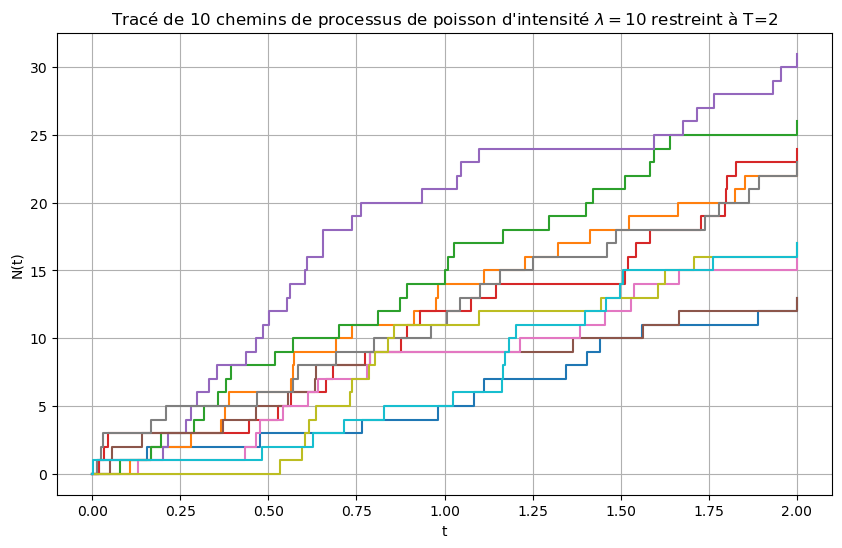

In [3]:
n = 10
lambd = 10
T = 2
sol = [ One_Poisson_Homogene_Inverse(lambd, T) for _ in range(n) ]


fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

for j in range(n):
    support = np.arange(len(sol[j]))
    ax.step(sol[j], support, where='post')
    
ax.grid()
ax.set_title(f"Tracé de {n} chemins de processus de poisson d'intensité $\lambda=${lambd} restreint à T={T}")
ax.set_xlabel('t')
ax.set_ylabel('N(t)')
plt.show()


#### Simulation d'un processus homogène par la méthode d'arrangement

Si $(N_t)_{t \ge 0}$ est un processus de Poisson d'intensité $\lambda > 0$, alors conditionnellement à l'événement $N_T = n$ les instants de sauts $(T_k)_{k=1,\dots,n}$ (tels que $0 < T_1 < \dots < T_n \le T$) ont même loi que le réordonnement croissant d'un vecteur $(U_1, \dots, U_n) \sim \mathcal{U}([0,T]^n)$.

In [4]:
def One_Poisson_Homogene_Sort(lambd, T):
    size = rng.poisson(lam=lambd*T)
    times = np.empty(size+2)
    times[0] = 0
    times[1:-1] = np.sort(rng.uniform(size=size, low=0, high=T))
    times[-1] = T
    return times

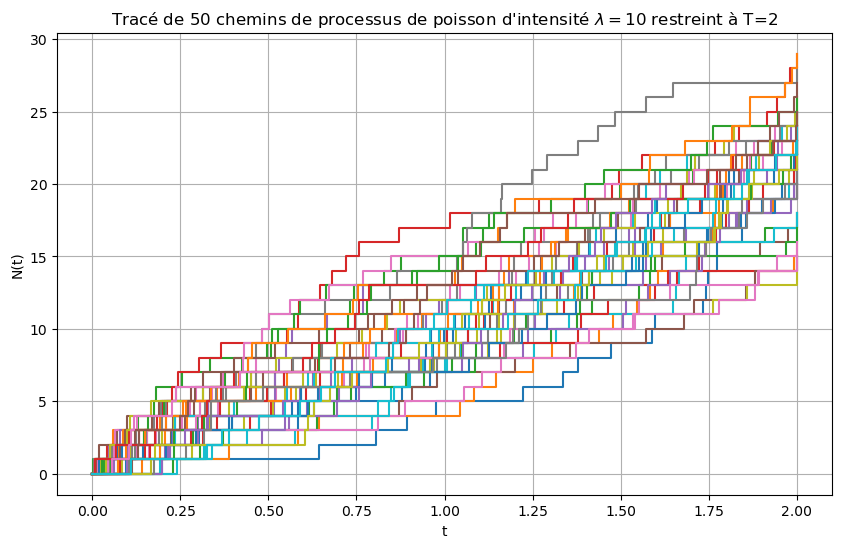

In [5]:
n = 50
lambd = 10
T = 2
sol = [ One_Poisson_Homogene_Sort(lambd, T) for _ in range(n) ]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

for j in range(n):
    support = np.arange(len(sol[j]))
    ax.step(sol[j], support, where='post')
    
ax.grid()
ax.set_title(f"Tracé de {n} chemins de processus de poisson d'intensité $\lambda=${lambd} restreint à T={T}")
ax.set_xlabel('t')
ax.set_ylabel('N(t)')
plt.show()

#### Convergence du processus d'intensité $\lambda$ restreint à T vers une loi de poisson $\lambda T$

Pour un temps t donné (strictement positif), le nombre $(N_t)$ d'occurrences dans un intervalle de longueur t suit une loi de Poisson d'intensité $\normalsize\lambda t$, c'est-à-dire que $\quad \mathbf{P} (N_t=k)=  e^{-\lambda t}\large\frac{(\lambda t)^{2}}{k!}$    



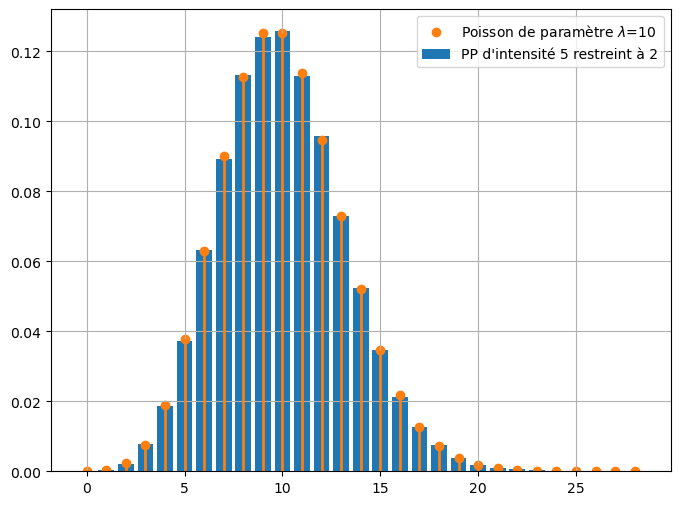

In [26]:
size = 100000
T = 2
lambd=5
poisson = stats.poisson(lambd*T)
sol  = [One_Poisson_Homogene_Inverse(lambd,T)[1:-1].size for _ in range(size)]
#Il faut exclure le premier et dernier point du calcul de taille, car le processus ne commence 
#véritablement qu'après avoir tiré une loi exponentielle inverse une fois, et la dernière
#valeur de sol est supérieur à T (on l'a transformé en T pour rendre le graphique plus beau,
#donc elle ne fait pas partie du processus. 


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
support = np.arange(np.max(sol)+1)
empirical_pro = np.bincount(sol,minlength=np.max(sol))/size
ax.bar(support,empirical_pro,label=f"PP d'intensité {lambd} restreint à {T}")
ax.scatter(support, poisson.pmf(support), label=f'Poisson de paramètre $\lambda$={lambd*T}')
ax.vlines(support, 0, poisson.pmf(support), color='C1', lw=2, alpha=1)
ax.grid()
ax.legend()
plt.show()

### Processus de poisson non homogène


On considère un processus de Poisson de paramètre (ou intensité) $\lambda(t)$ est une fonction de R+ vers R+ intégrable.
Le processus de comptage {$N_t,t ∈ {\rm I\!R+}$} est appelé un processus de poisson non homogène d'intensité $\lambda(t)$ si $N_t$ satisfait : 
- Les incréments de $N_t$ sont indépendants entre eux
- $N_0=0$
- pour tout $t ∈ {\rm I\!R+}$, on a : $\mathbf{P}(N_{t+h}-N_t = 1) = \lambda(t)h + o(h)$  et  $\mathbf{P}(N_{t+h}-N_t > 2) = o(h)$ 



In [47]:
#Quelques fonctions que nous utiliserons comme paramètre des processus non homogènes et une redéfinition de l'intégrale pour 
#simplifier la lecture

def integrale(f,a,b):
    return quad(f,a,b)[0]


def f1(x):
    return x**2
def f2(x):
    return 1 + np.sin(x)
def f3(x):
    return 10*stats.norm(loc=2,scale=1).pdf(x)
def f4(x):
    return (5+np.exp(-x))/(2+np.sin(x))

nom_fonction = ["$f(x)=x^{2}$", "$f(x)=1+sin(x)$", "densité de la loi normale de moyenne 2 et de variance 1","f4"]


#### Simulation d'un processus non homogène par la méthode de la fonction inverse

Soit $N_t$ un processus de Poisson non homogène de fonction d’intensité $\lambda$ et de fonction moyenne Λ tel que Λ(𝑡) =$\int_0^t \lambda(a)\,da$, alors $N_t$ suit une loi de Poisson de paramètre Λ(t). 

Pour simuler ce processus de poisson, il suffit donc de simuler un processsus de poisson homogène d'intensité 1, puis d'appliquer la transformation $T_k = Λ^{-1}(t_k)$ avec $t_k$ les temps d'arrivées du processus homogène. (Méthode Cinlar)

Cette méthode est couteuse, et il existe un autre algorithme fonctionnant sur le même procédé que j'ai utilisé ici :
Cette méthode utilise la distribution conditionnelle inter-élément.

On considére les $X_i = T_{i+1}-T_i$ conditionné par les évènements $T_1=t_1,T_2=t_2...T_i=t_i$, Alors on a : 

$F_{t_i}(x) = \mathbf{P}(X_i<x | T_1=t_1,T_2=t_2...T_i=t_i) $<br>$= \mathbf{P}(N_{t_i+x}-N_{t_i} \geq 1 | T_1=t_1,T_2=t_2...T_i=t_i)
$<br>$= \mathbf{P}(N_{t_i+x}-N_{t_i} \geq 1)$<br>$ = 1 - \mathbf{P}(N_{t_i+x}-N_{t_i} = 0) $<br>$= 1 - exp(-Λ(t_i+x) + Λ(t_i))$

Pour trouver le temps $T_k$, il suffit donc de générer U uniforme et de résoudre $x = inf(x : F_t(x)\geq u)$ 

In [8]:
#Calcul de x = inf(x : Ft(x) >= u)
def dichotomie(f,t,u,T, n=20):
    def Ft(x):
        return 1 - np.exp(-integrale(f,t,t+x))    
    
    a = 0
    b = T   
    for j in range(n):
        if Ft((a+b)/2)<u:
            a = (a+b)/2
        else : 
            b = (a+b)/2
    return (a+b)/2
    
def one_Poisson_nonHomogène_inversion(f,T):
       
    sol = [0]  
    while sol[-1]<T:        
        u = rng.uniform()
        t = dichotomie(f,sol[-1],u,T)
        sol.append(sol[-1]+t)
              
    sol[-1]=T
    return np.array(sol)

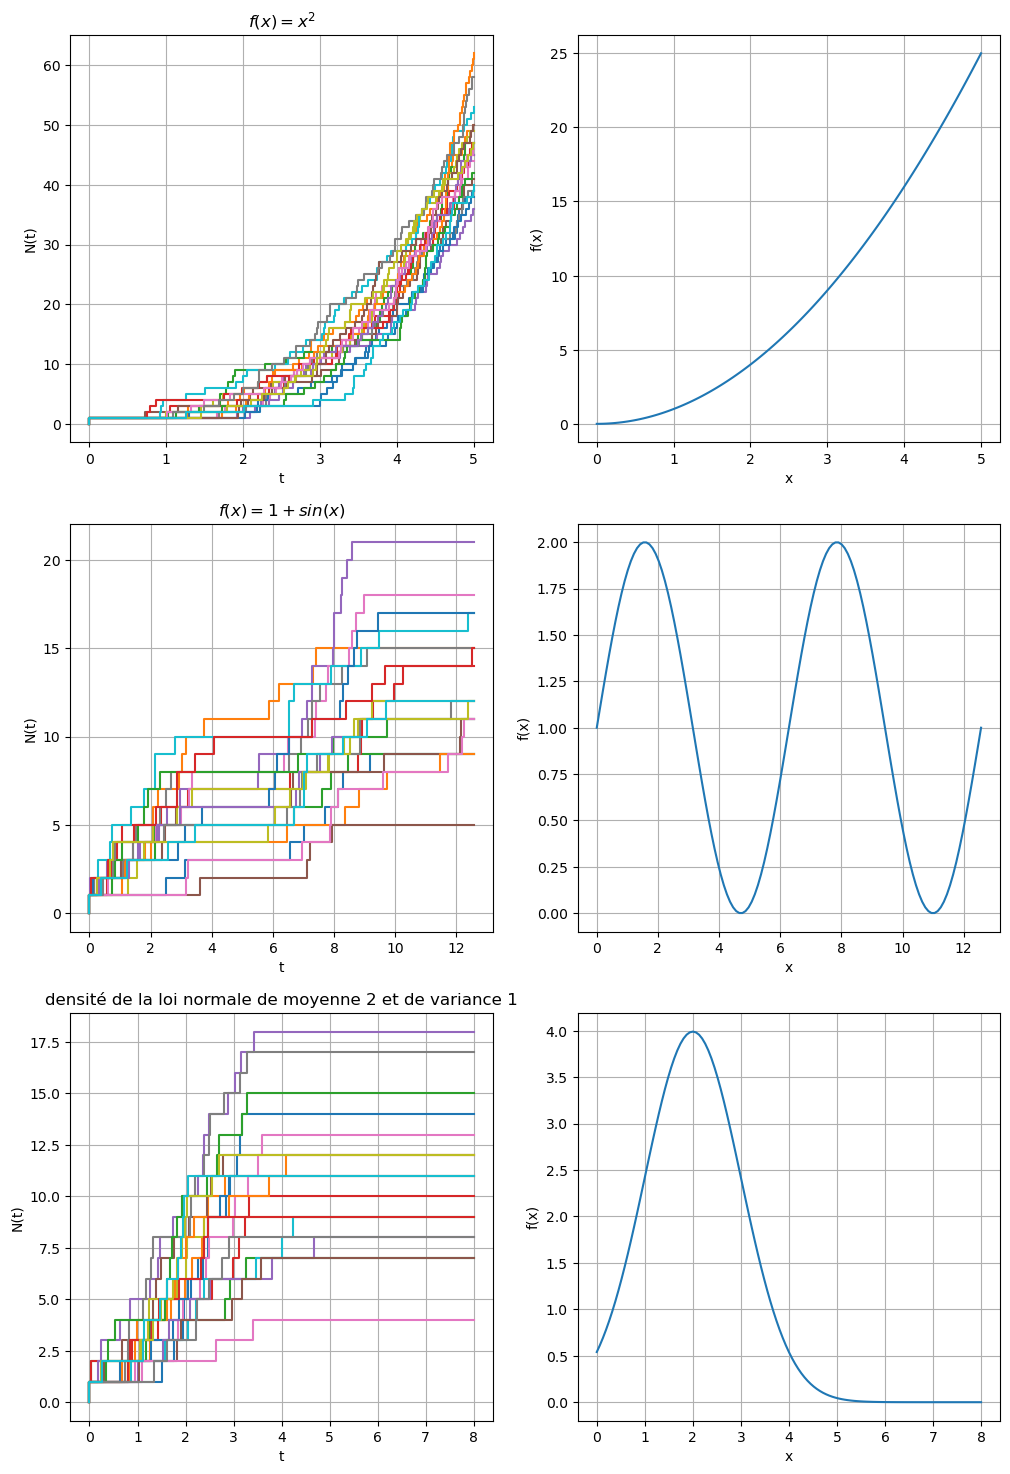

In [31]:
Ts = [5,4*np.pi,8]
n = 20
fs = [f1,f2,f3]
fig = plt.figure(figsize=(12,18))


for i in range(3):
    T = Ts[i]
    f = fs[i]
    sol = [one_Poisson_nonHomogène_inversion(f,T) for _ in range(n)]
    ax1 = fig.add_subplot(3,2,(2*i)+1)
    for j in range(n):
        support = np.arange(sol[j].size)
        ax1.step(sol[j],support)
    ax1.grid()
    ax1.set_xlabel('t')
    ax1.set_ylabel('N(t)')
    ax1.set_title(nom_fonction[i])
    
    xx = np.linspace(0,T,125)
    ax2 = fig.add_subplot(3,2,(2*i)+2)
    ax2.plot(xx,f(xx))
    ax2.grid()
    ax2.set_xlabel('x')
    ax2.set_ylabel('f(x)')
    

#### Convergence du processsus homogène d'intensité f restreint à T vers la loi de poisson d'intensité integrale $\int_0^t \lambda(a)\,da$
Le nombre d'arrivée dans n'importe quel interval d'un processus de poisson d'intensité $\lambda(t)$ suit une loi de Poisson.
Plus précisément, 
$$\normalsize  N_{t+s}-N_t \thicksim Poisson(\int_t^{t+s} \lambda(a)\,da)$$

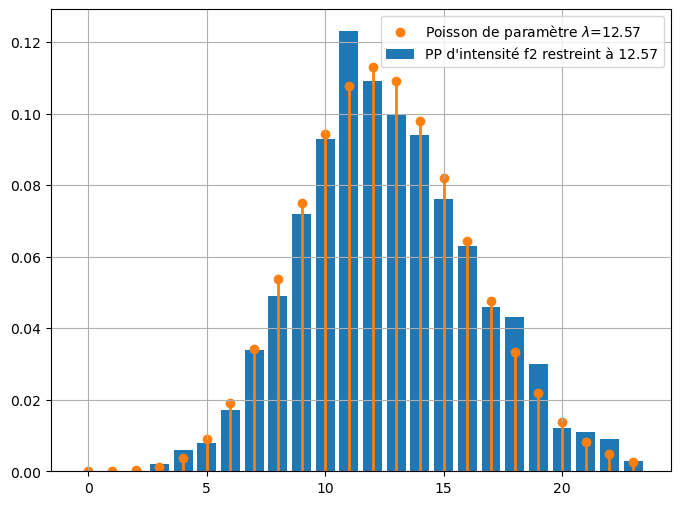

In [28]:
size = 1000
T = 4*np.pi
f = f2
lambd=integrale(f,0,T)
poisson = stats.poisson(lambd)
sol  = [one_Poisson_nonHomogène_inversion(f,T)[1:-1].size for _ in range(size)]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
support = np.arange(np.max(sol)+1)
empirical_pro = np.bincount(sol,minlength=np.max(sol))/size
ax.bar(support,empirical_pro,label=f"PP d'intensité f2 restreint à {round(T,2)}")
ax.scatter(support, poisson.pmf(support), label=f'Poisson de paramètre $\lambda$={round(lambd,2)}')
ax.vlines(support, 0, poisson.pmf(support), color='C1', lw=2, alpha=1)
ax.grid()
ax.legend()
plt.show()

## Partie 2 : Thinning algorithm



### Splitting d'un processus de poisson homogène par une loi de bernouilli 

On commence par une version basique mais très proche de la méthode de thinning, qui consiste simplement à diviser processus de poisson selon une loi de bernouilli

Soit $N_t$ un processus de poisson d'intensité $\lambda$. Si, pour chaque arrivée, on tire une variable de bernouilli B
de paramètre p, tel que si B=1 l'arrivée est envoyé vers le processus $N1_t$ et sinon vers $N2_t$, alors :

$N1_t$ est un processus de poisson homogène d'intensité $\lambda p$ et
$N2_t$ est un processus de poisson homogène d'intensité $(1-\lambda) p$

In [11]:
def One_Poisson_Splitting(lambd, T, p):
      
    process = One_Poisson_Homogene_Inverse(lambd, T)

    accep = [0]
    rejet = [0]
    U = rng.uniform(size=process.size)
    
    for i in range(process.size) :
       
        if U[i]<=p:
            accep.append(process[i])
        else : 
            rejet.append(process[i])
    return np.array(accep), np.array(rejet)
            
def Poisson_Splitting(lambd, T, p, sample_size):
    sol1 = []
    sol2 = []
    for j in range(sample_size):
        temp1,temp2 = One_Poisson_Splitting(lambd, T, p)
        sol1.append(temp1[1:-1].size)
        sol2.append(temp2[1:-1].size)
    return np.array(sol1), np.array(sol2)
        

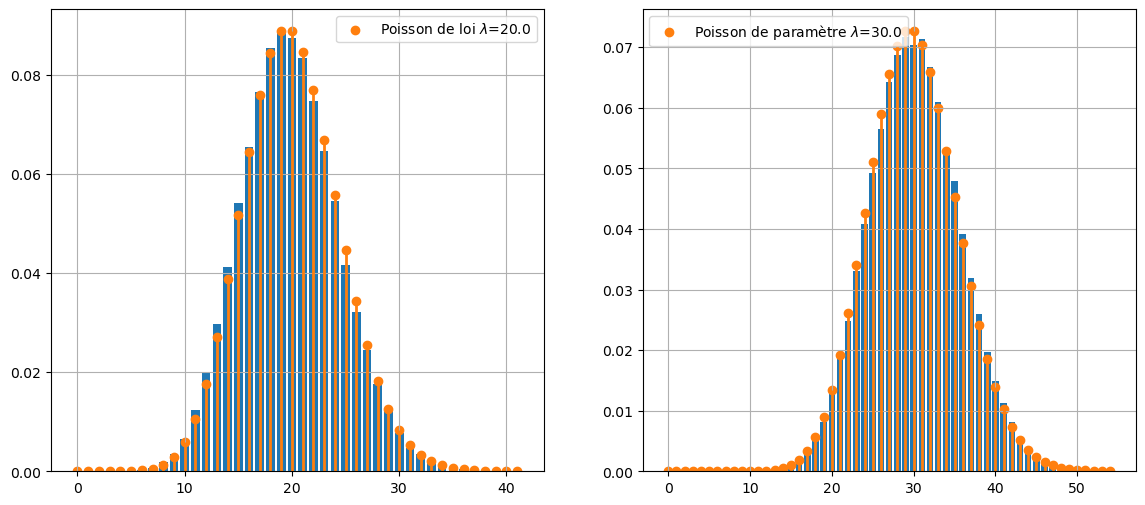

In [12]:
size = 100000
T = 10
lambd=5
p=0.4
poisson1 = stats.poisson(T*lambd*p)
poisson2 = stats.poisson(T*lambd*(1-p))
sol1,sol2  = Poisson_Splitting(lambd, T, p, size)


fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1,2,1)
support = np.arange(np.max(sol1)+1)
empirical_pro = np.bincount(sol1,minlength=np.max(sol1))/sol1.size
ax1.bar(support,empirical_pro)
ax1.scatter(support, poisson1.pmf(support), label=f'Poisson de loi $\lambda$={round(T*p*lambd,2)}')
ax1.vlines(support, 0, poisson1.pmf(support), color='C1', lw=2, alpha=1)
ax1.grid()
ax1.legend()


ax2 = fig.add_subplot(1,2,2)
support = np.arange(np.max(sol2)+1)
empirical_pro = np.bincount(sol2,minlength=np.max(sol2))/sol2.size
ax2.bar(support,empirical_pro)
ax2.scatter(support, poisson2.pmf(support), label=f'Poisson de paramètre $\lambda$={round((1-p)*lambd*T,2)}')
ax2.vlines(support, 0, poisson2.pmf(support), color='C1', lw=2, alpha=1)
ax2.grid()
ax2.legend()
plt.show()


### Simulation d'un processus non homogène par la méthode de thinning
Théorème de Lewis et Shedler : Soit un processus de Poisson d'intensité $\lambda_u(t), t\geq 0$. Supposons que
les $T_{1}^{*},T_{1}^{*},....,T_{n}^{*}$ sont des variables aléatoires représentant les temps d'arrivées pour ce processus de poisson, se situant entre 0 et T. Sois $\lambda(t)$ une fonction d'intensité telle que $0\leq \lambda(t) \leq(t) \lambda_u(t)$
pour $t ∈ [0,T]$. Si le i-ème temps d'arrivée $T_{i}^{*}$ est rejeté avec probabilité $1-\large\frac{\lambda(t)}{\lambda_u(t)}$ pour $i=1,2...n$, alors les points restant forment un processus de Poisson non homogène d'intensité $\lambda(t)$ restreint à $T$.

Pour la première implémentation, j'utilise $\lambda_u(t)=sup_t \lambda(t)$.

In [13]:
#Recherche du sup de f sur l'intervalle [0,T]
#Ici, je recherche le sup de manière très superficielle une premiere fois, car j'ai eu des problèmes avec la densité 
#de la loi normale. En particulier, si x0 commence loin de la moyenne, optimize.minimize n'arrive pas à trouver le sup
#et renvoit une valeur proche de 0. De plus, optimize.minize se retrouve parfois coincé dans des max locals.


def sup(f,t1,t2):
    intervalle = np.linspace(t1,t2,50)
    x0 = t1
    for x in intervalle:
        if(f(x)>f(x0)):
            x0 = x
    xmax = optimize.minimize(lambda x: -f(x), x0, bounds=[(t1,t2)]).x[0]
    return f(xmax)

In [14]:
def Poisson_nonHomogène_thinning(f,T):
    
    
    lambd = sup(f,0,T)
        
    #Generation d'un processus de poisson d'intensité lambd (le max qu'on a trouvé)
    #en utilisant un arrangement
    
    process = One_Poisson_Homogene_Sort(lambd,T)

    #On garde uniquement les points qui valide le critère 
    sol = [0]
    for p in process :
       
        d = rng.uniform()
        if d<=f(p)/lambd:
            sol.append(p)
    sol[-1]=T
    return np.array(sol)


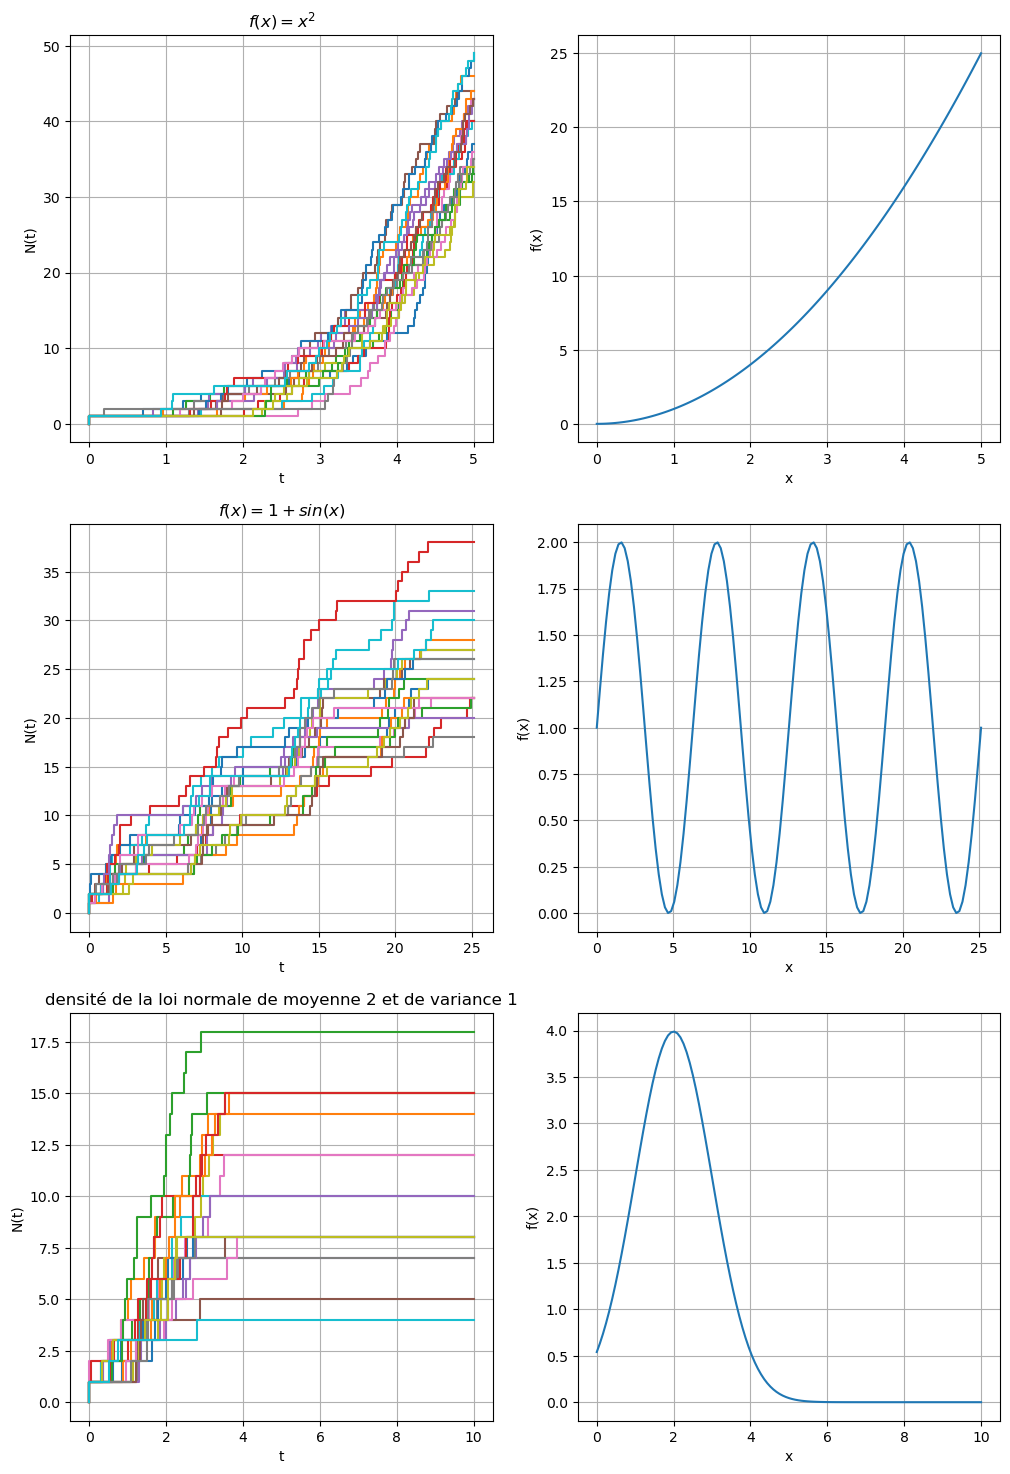

In [49]:
Ts = [5,8*np.pi,10]
n = 20
fs = [f1,f2,f3]
fig = plt.figure(figsize=(12,18))


for i in range(3):
    T = Ts[i]
    f = fs[i]
    sol  = [Poisson_nonHomogène_thinning(f,T) for _ in range(n)]
    ax1 = fig.add_subplot(3,2,(2*i)+1)
    for j in range(n):
        support = np.arange(sol[j].size)
        ax1.step(sol[j],support)
    ax1.grid()
    ax1.set_xlabel('t')
    ax1.set_ylabel('N(t)')
    ax1.set_title(nom_fonction[i])
    
    xx = np.linspace(0,T,125)
    ax2 = fig.add_subplot(3,2,(2*i)+2)
    ax2.plot(xx,f(xx))
    ax2.grid()
    ax2.set_xlabel('x')
    ax2.set_ylabel('f(x)')

plt.show()

        

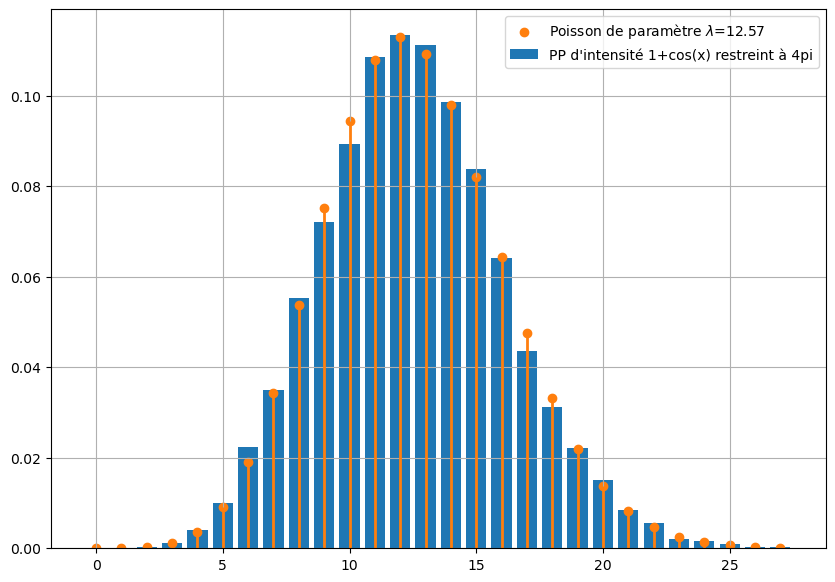

In [16]:
size = 10000
T = 4*np.pi
f = f2
lambd=integrale(f,0,T)
poisson = stats.poisson(lambd)
sol  = [Poisson_nonHomogène_thinning(f,T)[1:-1].size for _ in range(size)]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
support = np.arange(np.max(sol)+1)
empirical_pro = np.bincount(sol,minlength=np.max(sol))/size
ax.bar(support,empirical_pro,label=f"PP d'intensité 1+cos(x) restreint à 4pi")
ax.scatter(support, poisson.pmf(support), label=f'Poisson de paramètre $\lambda$={round(lambd,2)}')
ax.vlines(support, 0, poisson.pmf(support), color='C1', lw=2, alpha=1)
ax.grid()
ax.legend()
plt.show()

#### Illustration de la méthode de thinning

In [53]:
#Je réécris la méthode pour l'illustration plus bas

def Poisson_nonHomogène_thinning_illustration(f,T):
    
    #Recherche du sup de f sur l'intervalle [0,T]
    
    lambd = sup(f,0,T)
    
    #Generation d'un processus de poisson d'intensité lambd (le max qu'on a trouvé)
    #en utilisant un arrangement
    
    process = One_Poisson_Homogene_Sort(lambd,T)
 
    accep = []
    rejet = []
    accepd = []
    rejetd = []
    for p in process :
       
        d = rng.uniform()
        if d<=f(p)/lambd:
            accep.append(p)
            accepd.append(d*lambd)
        else : 
            rejet.append(p)
            rejetd.append(d*lambd)
    sol[-1]=T
    return np.array(accep),np.array(rejet),np.array(accepd),np.array(rejetd)

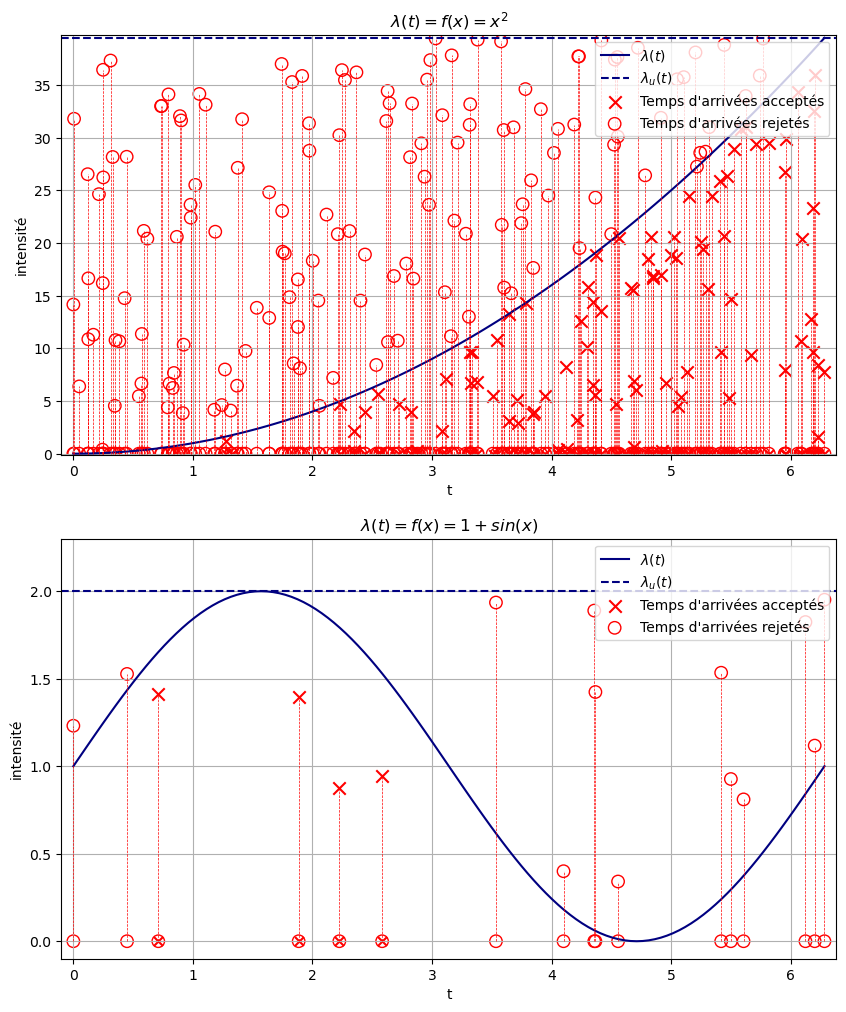

In [34]:
T = 2*np.pi
fs = [f1,f2]
fig = plt.figure(figsize=(10,6*len(fs)))


for i,f in enumerate(fs):
    lambd = sup(f,0,T)
    accep, rejet, accepd, rejetd = Poisson_nonHomogène_thinning_illustration(f,T)

    ax = fig.add_subplot(len(fs),1,i+1)

    xx = np.linspace(0,T,125)
    ax.plot(xx,f(xx),label="$\lambda(t)$",color='navy')
    ax.axhline(y=lambd,linestyle='--',label="$\lambda_u(t)$",color='navy')

    ax.scatter(accep,np.zeros(accep.size), s=80, facecolors='none', edgecolors='r')
    ax.scatter(accep,accepd, marker='x', s=80,color='r',label="Temps d'arrivées acceptés")
    ax.scatter(accep,np.zeros(accep.size), marker='x', s=40,color='r')

    ax.scatter(rejet,np.zeros(rejet.size), s=80, facecolors='none', edgecolors='r',label="Temps d'arrivées rejetés")
    ax.scatter(rejet,rejetd, s=80, facecolors='none', edgecolors='r')

    for j in range(accep.size):
        ax.plot(np.array([accep[j],accep[j]]),np.array([0,accepd[j]]),linestyle='--',color='r',linewidth=0.5)
    for j in range(rejet.size):
        ax.plot(np.array([rejet[j],rejet[j]]),np.array([0,rejetd[j]]),linestyle='--',color='r',linewidth=0.5)

    ax.set_xlim(-0.1,T+0.1)
    ax.set_ylim(-0.1,lambd+0.3)
    ax.grid()
    ax.set_xlabel('t')
    ax.set_ylabel('intensité')
    ax.set_title(f"$\lambda(t)=${nom_fonction[i]}")
    ax.legend(loc="upper right")
plt.show()

### Simulation d'un processus non homogène par une méthode de thinning subdivisée

Pour optimiser l'algorithme, on va chercher à réduire au maximul le nombre de points rejetés. Au lieu d'utiliser 
$\lambda_u(t)=sup_t \lambda(t)$, on divise la fonction en plusieurs morceaux et on calcule $\lambda_u(t)$ pour chaque morceau. 


In [24]:
def Poisson_nonHomogène_subdivision(f,T):
        
        
    nb_intervalles = 4   
    sol = [0]
    intervalles = np.linspace(0,T,nb_intervalles+1)
    for T_temp,T_temp_avant in zip(intervalles[1:],intervalles[:-1]):
           
        lambd_u = sup(f,T_temp_avant,T_temp)    
        process = One_Poisson_Homogene_Inverse(lambd_u,T_temp)[1:-1] + sol[-1]
        
        i = 0 
        while sol[-1]<T_temp and i<process.size:
            d = rng.uniform()
            if d<=f(process[i])/lambd_u:
                sol.append(process[i])
            i+=1          
            
    sol[-1]=T
    return np.array(sol)

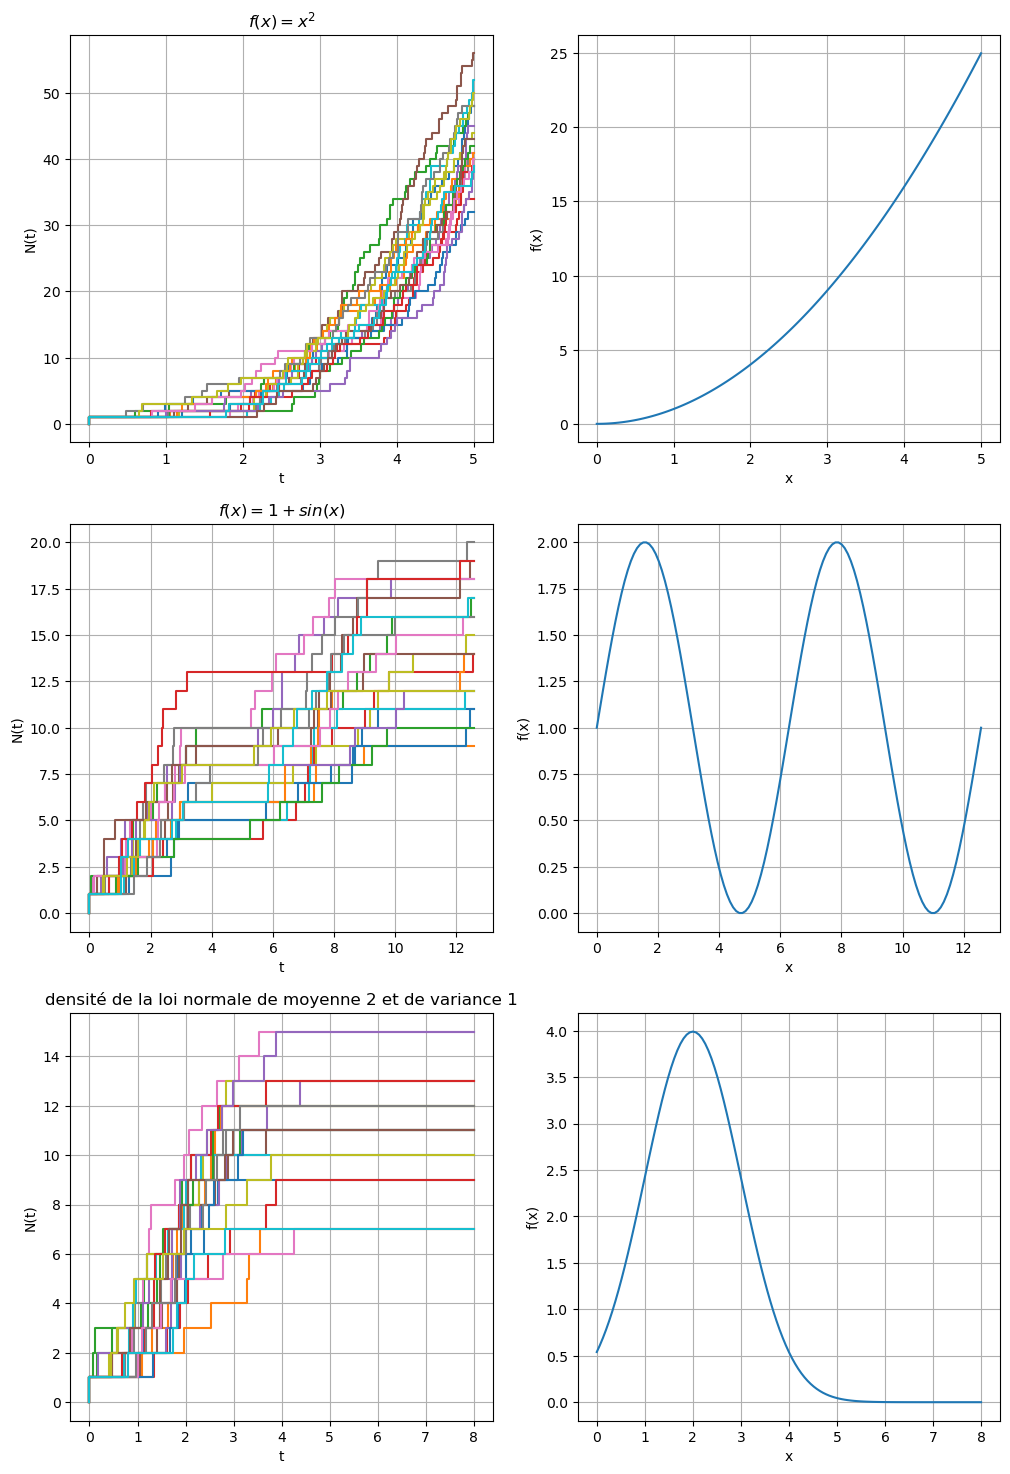

In [35]:
Ts = [5,4*np.pi,8]
n = 20
fs = [f1,f2,f3]
fig = plt.figure(figsize=(12,18))


for i in range(3):
    T = Ts[i]
    f = fs[i]
    sol  = [Poisson_nonHomogène_subdivision(f,T) for _ in range(n)]
    ax1 = fig.add_subplot(3,2,(2*i)+1)
    for j in range(n):
        support = np.arange(sol[j].size)
        ax1.step(sol[j],support)
    ax1.grid()
    ax1.set_xlabel('t')
    ax1.set_ylabel('N(t)')
    ax1.set_title(nom_fonction[i])
    
    xx = np.linspace(0,T,125)
    ax2 = fig.add_subplot(3,2,(2*i)+2)
    ax2.plot(xx,f(xx))
    ax2.grid()
    ax2.set_xlabel('x')
    ax2.set_ylabel('f(x)')

plt.show()



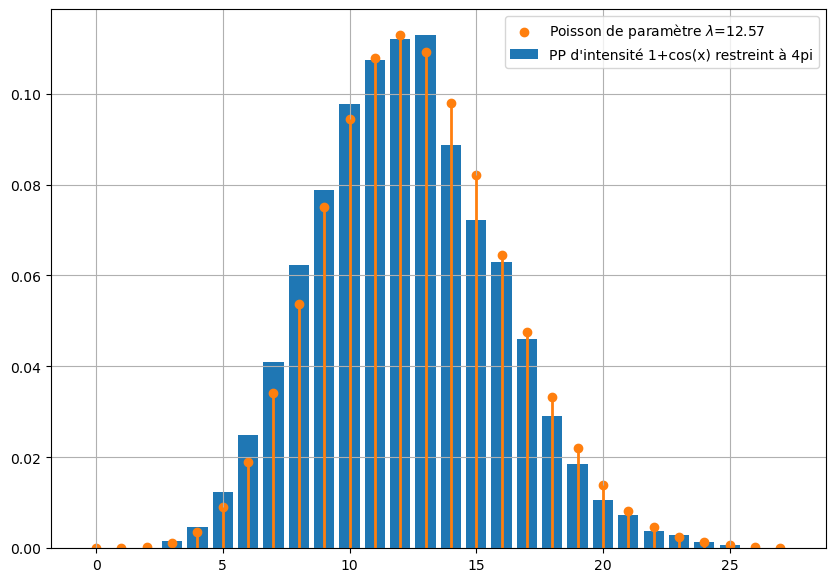

In [21]:
size = 10000
T = 4*np.pi
f = f2
lambd=integrale(f,0,T)
poisson = stats.poisson(lambd)
sol  = [-1+Poisson_nonHomogène_subdivision(f,T)[1:-1].size for _ in range(size)]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
support = np.arange(np.max(sol)+1)
empirical_pro = np.bincount(sol,minlength=np.max(sol))/size
ax.bar(support,empirical_pro,label=f"PP d'intensité 1+cos(x) restreint à 4pi")
ax.scatter(support, poisson.pmf(support), label=f'Poisson de paramètre $\lambda$={round(lambd,2)}')
ax.vlines(support, 0, poisson.pmf(support), color='C1', lw=2, alpha=1)
ax.grid()
ax.legend()
plt.show()

## Partie 3 : Comparaison des performances

Nous avons donc écrit 3 algorithmes pour simuler un processus de poisson non homogène. Il faut maintenant comparer leurs performances en utilisant divers fonctions.

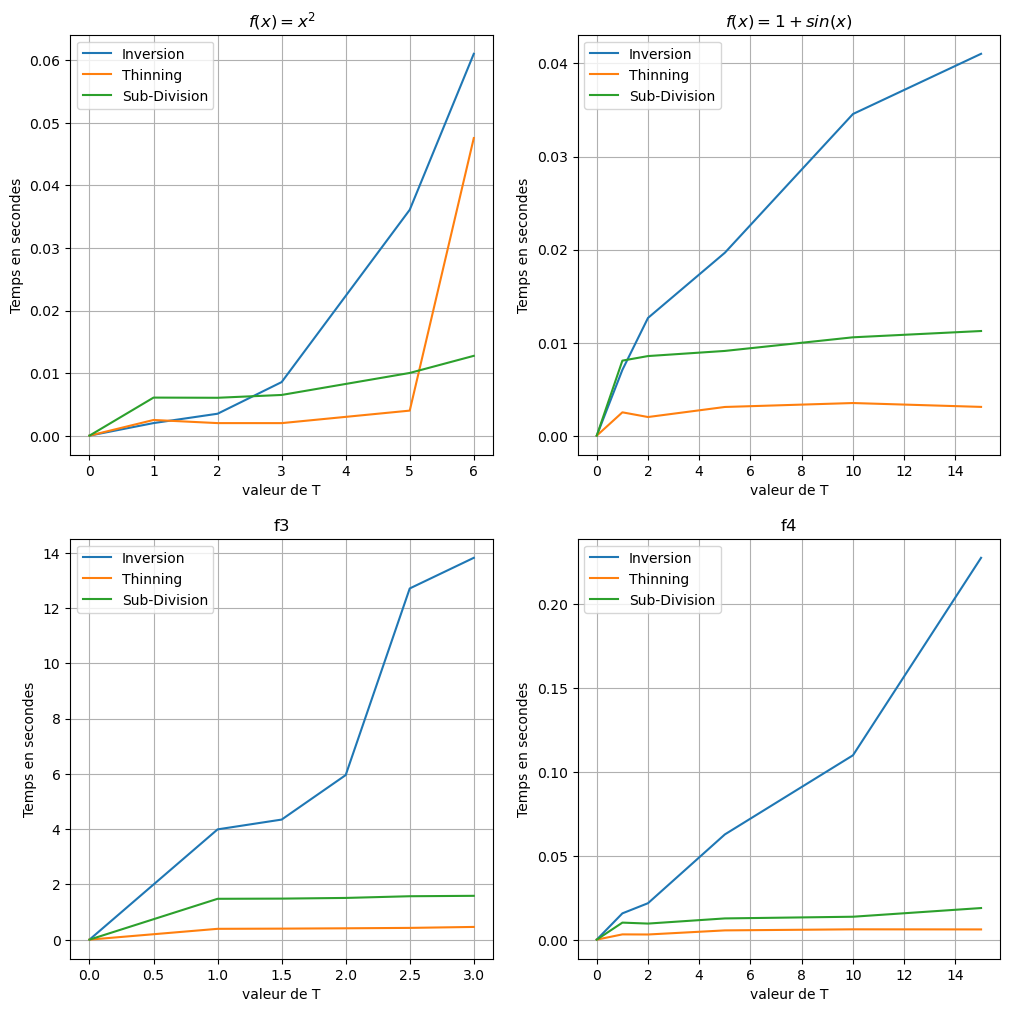

In [22]:
#ATTENTION : Ne pas relancer cette cellule, elle prend un temps conséquent à s'exécuter 

Ts = np.array([[0,1,2,3,5,6],[0,1,2,5,10,15],[0,1,1.5,2,2.5,3],[0,1,2,5,10,15]])
fs = [f1,f2,f3,f4]
fig = plt.figure(figsize=(12,12))

methodes = [one_Poisson_nonHomogène_inversion, 
           Poisson_nonHomogène_thinning,
           Poisson_nonHomogène_subdivision]

nom = ['Inversion','Thinning','Sub-Division']
titre = ['$f(x)=x^{2}$','$f(x)=1+sin(x)$','f3','f4']
for i,f in enumerate(fs) : 
    temps = [[0],[0],[0]]

    for T in Ts[i,1:]:
        for t,m in zip(temps,methodes):
            start = time.time()
            sol = [m(f,T) for _ in range(10)]
            end = time.time()
            t.append(end-start)
        
    ax = fig.add_subplot(2,2,i+1)
    for j,t in enumerate(temps):
        ax.plot(Ts[i],t,label=nom[j])
    ax.legend()
    ax.grid()
    ax.set_title(titre[i])
    ax.set_xlabel('valeur de T')
    ax.set_ylabel('Temps en secondes')
plt.show()
    

Clairement, la méthode de thinning et sa variance sont bien plus rapide que la méthode d'inversion.
On va comparer plus en détail ces deux méthodes : 

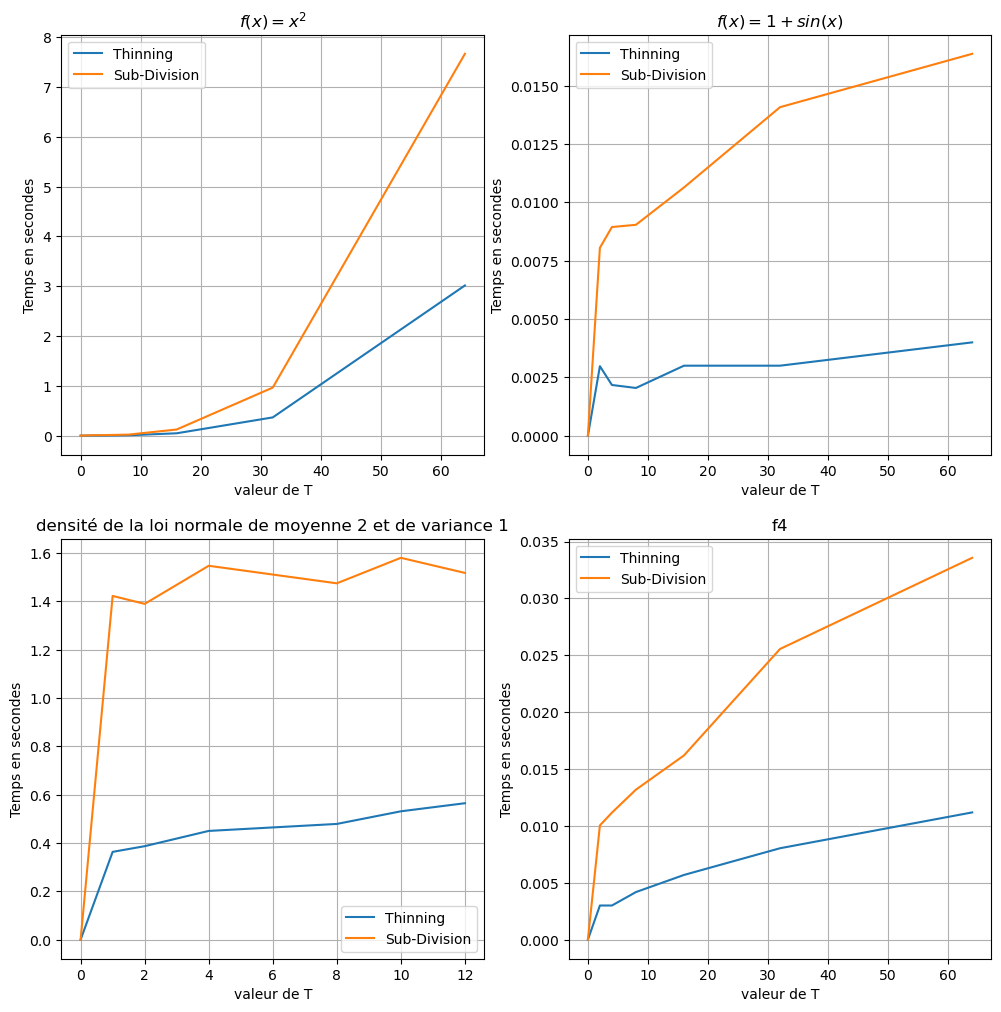

In [51]:
Ts = np.array([[0,2,4,8,16,32,64],[0,2,4,8,16,32,64],[0,1,2,4,8,10,12],[0,2,4,8,16,32,64]])
fs = [f1,f2,f3,f4]
fig = plt.figure(figsize=(12,12))

methodes = [Poisson_nonHomogène_thinning, Poisson_nonHomogène_subdivision]

nom = ['Thinning','Sub-Division']
for i,f in enumerate(fs) : 
    temps = [[0],[0]]

    for T in Ts[i,1:]:
        for t,m in zip(temps,methodes):
            start = time.time()
            sol = [m(f,T) for _ in range(10)]
            end = time.time()
            t.append(end-start)
        
    ax = fig.add_subplot(2,2,i+1)
    for j,t in enumerate(temps):
        ax.plot(Ts[i],t,label=nom[j])
    ax.legend()
    ax.grid()
    ax.set_title(nom_fonction[i])
    ax.set_xlabel('valeur de T')
    ax.set_ylabel('Temps en secondes')
plt.show()

On remarque que la méthode de thinning de base est meilleur dans la plupart des cas, mais la différence reste faible.
La méthode alternative n'a de l'interêt que dans le cas ou $f(x)=x^{2}$. l'explication est intuitevement claire,
comme cette fonction croit rapidement, ne calculer que une seule fois son maximum entraine un nombre important de 
rejet. Dans ce cas, il est pertinent d'utiliser la méthode de sub-division. 

Il serait donc intéressant de choisir le nombre de sub-division selon les variations de f(x). En particulier, on pourrait chercher à créer des sub-divisions plus optimales de $f(x)$.